In [1]:
import json
import random
import os, datetime
import glob
import cv2
import tensorflow as tf
import pathlib
import numpy as np
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Creating future datasets
x_train = []
y_train = []
x_test = []
y_test = []
y_val = []
x_val = []

# Fix random seed
tf.random.set_seed(43)

In [3]:
# # Data augmentation
# datagen = ImageDataGenerator(
#         rotation_range=10,  
#         zoom_range = 0.10,  
#         width_shift_range=0.1, 
#         height_shift_range=0.1)

In [4]:
data_paths = [r"no_human2_test.txt",
              r"annotated_thermal_1.txt",
              r"annotated_2nd_dataset2.txt"]
frames = []
data = []
# Filling frames list with data from dataset
for path in data_paths:
    for line in open(path, 'r'):
        frames.append(json.loads(line))
#randomly mixing data to prevent learning on weakly changing pictures      
frames = random.sample(frames, len(frames))
print(len(frames))

9200


In [5]:
#Split data for testing, validation and training
cnt = 0
for frame in frames:
    if cnt == 0:
        x_train.append(frame['data'])
        y_train.append(frame['PeopleCount'])
    if cnt == 1:
        x_test.append(frame['data'])
        y_test.append(frame['PeopleCount'])
    if cnt == 2:
        x_val.append(frame['data'])
        y_val.append(frame['PeopleCount'])
    cnt += 1
    if cnt == 3:
        cnt = 0

print(len(x_train), len(y_train), len(x_test), len(y_test), len(x_val), len(y_val))
    
# train, test, verify datasets

3067 3067 3067 3067 3066 3066


In [6]:
# Convert data into numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
x_val = np.asarray(x_val)

# Checking data shapes are correct
print(x_train.shape,
x_test.shape,
x_val.shape,
y_train.shape,
y_test.shape,
y_val.shape)
print(x_train.shape[1:])

(3067, 32, 32) (3067, 32, 32) (3066, 32, 32) (3067,) (3067,) (3066,)
(32, 32)


In [7]:
# Export saved model
export_dir = 'mymodel'


In [8]:
# Create LeNet model based on source: https://medium.com/analytics-vidhya/lenet-with-tensorflow-a35da0d503df
# This architecture was used and optimised during HW3 to fit for STM32
# During comparison with other architectures like MobileNet V2 and Resnet-152 showed comparable results on MNIST dataset.
# Advantage of LeNet acrchitecture over MobileNet V2 and Resnet-152 is light weight.

model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=(32, 32, 1)))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(10, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(54, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                            

In [9]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [10]:
#Train model

history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val))

Epoch 1/1000
96/96 [==============================] - 22s 14ms/step - loss: 1.2080 - accuracy: 0.5377 - val_loss: 1.1775 - val_accuracy: 0.5476
Epoch 2/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.1926 - accuracy: 0.5406 - val_loss: 1.1771 - val_accuracy: 0.5476
Epoch 3/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.1920 - accuracy: 0.5406 - val_loss: 1.1774 - val_accuracy: 0.5476
Epoch 4/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.1908 - accuracy: 0.5406 - val_loss: 1.1792 - val_accuracy: 0.5476
Epoch 5/1000
96/96 [==============================] - 1s 5ms/step - loss: 1.1905 - accuracy: 0.5406 - val_loss: 1.1767 - val_accuracy: 0.5476
Epoch 6/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.1913 - accuracy: 0.5406 - val_loss: 1.1771 - val_accuracy: 0.5476
Epoch 7/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.1896 - accuracy: 0.5406 - val_loss: 1.1795 - val_accuracy: 0.5476
Epoc

96/96 [==============================] - 1s 5ms/step - loss: 0.3602 - accuracy: 0.8539 - val_loss: 0.2629 - val_accuracy: 0.9064
Epoch 59/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.3513 - accuracy: 0.8546 - val_loss: 0.2827 - val_accuracy: 0.8911
Epoch 60/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.3305 - accuracy: 0.8611 - val_loss: 0.2377 - val_accuracy: 0.9188
Epoch 61/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.3371 - accuracy: 0.8644 - val_loss: 0.2734 - val_accuracy: 0.9113
Epoch 62/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.3614 - accuracy: 0.8471 - val_loss: 0.2558 - val_accuracy: 0.8823
Epoch 63/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.3334 - accuracy: 0.8604 - val_loss: 0.2369 - val_accuracy: 0.9025
Epoch 64/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.3273 - accuracy: 0.8608 - val_loss: 0.2258 - val_accuracy: 0.9250
Epoch 65/1000

96/96 [==============================] - 1s 7ms/step - loss: 0.2564 - accuracy: 0.9048 - val_loss: 0.2519 - val_accuracy: 0.9015
Epoch 116/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.2449 - accuracy: 0.9103 - val_loss: 0.1797 - val_accuracy: 0.9256
Epoch 117/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.2430 - accuracy: 0.9048 - val_loss: 0.1736 - val_accuracy: 0.9292
Epoch 118/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.2598 - accuracy: 0.8979 - val_loss: 0.1820 - val_accuracy: 0.9325
Epoch 119/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.2518 - accuracy: 0.9048 - val_loss: 0.2073 - val_accuracy: 0.9204
Epoch 120/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.2344 - accuracy: 0.9071 - val_loss: 0.1937 - val_accuracy: 0.9243
Epoch 121/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.2370 - accuracy: 0.9110 - val_loss: 0.2131 - val_accuracy: 0.9204
Epoch 1

Epoch 172/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.2004 - accuracy: 0.9227 - val_loss: 0.2136 - val_accuracy: 0.9149
Epoch 173/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.2168 - accuracy: 0.9156 - val_loss: 0.1611 - val_accuracy: 0.9354
Epoch 174/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.2066 - accuracy: 0.9214 - val_loss: 0.1555 - val_accuracy: 0.9367
Epoch 175/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.2250 - accuracy: 0.9129 - val_loss: 0.1652 - val_accuracy: 0.9413
Epoch 176/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.2156 - accuracy: 0.9123 - val_loss: 0.1789 - val_accuracy: 0.9318
Epoch 177/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.2130 - accuracy: 0.9221 - val_loss: 0.1676 - val_accuracy: 0.9393
Epoch 178/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.2096 - accuracy: 0.9224 - val_loss: 0.1639 - val_accuracy:

Epoch 229/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1893 - accuracy: 0.9227 - val_loss: 0.1400 - val_accuracy: 0.9468
Epoch 230/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1978 - accuracy: 0.9201 - val_loss: 0.1418 - val_accuracy: 0.9410
Epoch 231/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1831 - accuracy: 0.9250 - val_loss: 0.1796 - val_accuracy: 0.9247
Epoch 232/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1908 - accuracy: 0.9266 - val_loss: 0.1701 - val_accuracy: 0.9377
Epoch 233/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1949 - accuracy: 0.9247 - val_loss: 0.1497 - val_accuracy: 0.9374
Epoch 234/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1870 - accuracy: 0.9312 - val_loss: 0.2056 - val_accuracy: 0.9155
Epoch 235/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1957 - accuracy: 0.9221 - val_loss: 0.1384 - val_accuracy:

Epoch 286/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1789 - accuracy: 0.9286 - val_loss: 0.1294 - val_accuracy: 0.9442
Epoch 287/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1765 - accuracy: 0.9299 - val_loss: 0.1808 - val_accuracy: 0.9328
Epoch 288/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1783 - accuracy: 0.9306 - val_loss: 0.1522 - val_accuracy: 0.9419
Epoch 289/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1741 - accuracy: 0.9328 - val_loss: 0.1341 - val_accuracy: 0.9403
Epoch 290/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1859 - accuracy: 0.9270 - val_loss: 0.1429 - val_accuracy: 0.9455
Epoch 291/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1801 - accuracy: 0.9309 - val_loss: 0.1366 - val_accuracy: 0.9459
Epoch 292/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1706 - accuracy: 0.9322 - val_loss: 0.1374 - val_accuracy:

Epoch 343/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1595 - accuracy: 0.9364 - val_loss: 0.1271 - val_accuracy: 0.9514
Epoch 344/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1649 - accuracy: 0.9335 - val_loss: 0.1264 - val_accuracy: 0.9501
Epoch 345/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1676 - accuracy: 0.9351 - val_loss: 0.1285 - val_accuracy: 0.9459
Epoch 346/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1592 - accuracy: 0.9381 - val_loss: 0.1259 - val_accuracy: 0.9501
Epoch 347/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1718 - accuracy: 0.9338 - val_loss: 0.1382 - val_accuracy: 0.9472
Epoch 348/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1665 - accuracy: 0.9345 - val_loss: 0.1354 - val_accuracy: 0.9475
Epoch 349/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1685 - accuracy: 0.9361 - val_loss: 0.1201 - val_accuracy:

Epoch 400/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1621 - accuracy: 0.9367 - val_loss: 0.1311 - val_accuracy: 0.9511
Epoch 401/1000
96/96 [==============================] - 0s 5ms/step - loss: 0.1494 - accuracy: 0.9426 - val_loss: 0.1284 - val_accuracy: 0.9556
Epoch 402/1000
96/96 [==============================] - 0s 5ms/step - loss: 0.1666 - accuracy: 0.9319 - val_loss: 0.1551 - val_accuracy: 0.9410
Epoch 403/1000
96/96 [==============================] - 0s 5ms/step - loss: 0.1654 - accuracy: 0.9397 - val_loss: 0.1258 - val_accuracy: 0.9472
Epoch 404/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1815 - accuracy: 0.9312 - val_loss: 0.1271 - val_accuracy: 0.9556
Epoch 405/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1533 - accuracy: 0.9390 - val_loss: 0.1192 - val_accuracy: 0.9583
Epoch 406/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1577 - accuracy: 0.9390 - val_loss: 0.1163 - val_accuracy:

Epoch 457/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1575 - accuracy: 0.9423 - val_loss: 0.1215 - val_accuracy: 0.9566
Epoch 458/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1455 - accuracy: 0.9498 - val_loss: 0.1267 - val_accuracy: 0.9504
Epoch 459/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1593 - accuracy: 0.9374 - val_loss: 0.1305 - val_accuracy: 0.9481
Epoch 460/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1594 - accuracy: 0.9345 - val_loss: 0.1255 - val_accuracy: 0.9556
Epoch 461/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9354 - val_loss: 0.1141 - val_accuracy: 0.9576
Epoch 462/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1531 - accuracy: 0.9374 - val_loss: 0.1267 - val_accuracy: 0.9540
Epoch 463/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1541 - accuracy: 0.9403 - val_loss: 0.1216 - val_accuracy:

Epoch 514/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1517 - accuracy: 0.9345 - val_loss: 0.1325 - val_accuracy: 0.9537
Epoch 515/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1561 - accuracy: 0.9377 - val_loss: 0.1177 - val_accuracy: 0.9524
Epoch 516/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1591 - accuracy: 0.9387 - val_loss: 0.1363 - val_accuracy: 0.9478
Epoch 517/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1573 - accuracy: 0.9397 - val_loss: 0.1164 - val_accuracy: 0.9579
Epoch 518/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1510 - accuracy: 0.9429 - val_loss: 0.1154 - val_accuracy: 0.9556
Epoch 519/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1436 - accuracy: 0.9472 - val_loss: 0.1317 - val_accuracy: 0.9530
Epoch 520/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1497 - accuracy: 0.9413 - val_loss: 0.1174 - val_accuracy:

Epoch 571/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1587 - accuracy: 0.9397 - val_loss: 0.1306 - val_accuracy: 0.9569
Epoch 572/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1503 - accuracy: 0.9400 - val_loss: 0.1309 - val_accuracy: 0.9491
Epoch 573/1000
96/96 [==============================] - 1s 6ms/step - loss: 0.1399 - accuracy: 0.9433 - val_loss: 0.1342 - val_accuracy: 0.9514
Epoch 574/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.9452 - val_loss: 0.1445 - val_accuracy: 0.9511
Epoch 575/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1477 - accuracy: 0.9446 - val_loss: 0.1052 - val_accuracy: 0.9609
Epoch 576/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1466 - accuracy: 0.9446 - val_loss: 0.1261 - val_accuracy: 0.9508
Epoch 577/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1455 - accuracy: 0.9449 - val_loss: 0.1278 - val_accuracy:

Epoch 628/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1373 - accuracy: 0.9491 - val_loss: 0.1207 - val_accuracy: 0.9524
Epoch 629/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1357 - accuracy: 0.9446 - val_loss: 0.1224 - val_accuracy: 0.9556
Epoch 630/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1420 - accuracy: 0.9459 - val_loss: 0.1180 - val_accuracy: 0.9573
Epoch 631/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1571 - accuracy: 0.9367 - val_loss: 0.1132 - val_accuracy: 0.9596
Epoch 632/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1394 - accuracy: 0.9455 - val_loss: 0.1137 - val_accuracy: 0.9596
Epoch 633/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.9429 - val_loss: 0.1456 - val_accuracy: 0.9436
Epoch 634/1000
96/96 [==============================] - 1s 5ms/step - loss: 0.1455 - accuracy: 0.9423 - val_loss: 0.1180 - val_accuracy:

Epoch 685/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1399 - accuracy: 0.9475 - val_loss: 0.1116 - val_accuracy: 0.9589
Epoch 686/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1307 - accuracy: 0.9459 - val_loss: 0.1227 - val_accuracy: 0.9517
Epoch 687/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1553 - accuracy: 0.9459 - val_loss: 0.1435 - val_accuracy: 0.9472
Epoch 688/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1413 - accuracy: 0.9446 - val_loss: 0.1280 - val_accuracy: 0.9563
Epoch 689/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1258 - accuracy: 0.9495 - val_loss: 0.1117 - val_accuracy: 0.9576
Epoch 690/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1434 - accuracy: 0.9420 - val_loss: 0.1137 - val_accuracy: 0.9560
Epoch 691/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1383 - accuracy: 0.9498 - val_loss: 0.1256 - val_accuracy:

Epoch 742/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1329 - accuracy: 0.9488 - val_loss: 0.1083 - val_accuracy: 0.9540
Epoch 743/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1267 - accuracy: 0.9534 - val_loss: 0.1237 - val_accuracy: 0.9589
Epoch 744/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1381 - accuracy: 0.9442 - val_loss: 0.1163 - val_accuracy: 0.9602
Epoch 745/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1393 - accuracy: 0.9469 - val_loss: 0.1138 - val_accuracy: 0.9599
Epoch 746/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1347 - accuracy: 0.9491 - val_loss: 0.1026 - val_accuracy: 0.9589
Epoch 747/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1350 - accuracy: 0.9514 - val_loss: 0.1317 - val_accuracy: 0.9589
Epoch 748/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1387 - accuracy: 0.9410 - val_loss: 0.1124 - val_accuracy:

Epoch 799/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1399 - accuracy: 0.9482 - val_loss: 0.1135 - val_accuracy: 0.9605
Epoch 800/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1386 - accuracy: 0.9446 - val_loss: 0.1322 - val_accuracy: 0.9534
Epoch 801/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1266 - accuracy: 0.9524 - val_loss: 0.1100 - val_accuracy: 0.9589
Epoch 802/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1281 - accuracy: 0.9521 - val_loss: 0.1136 - val_accuracy: 0.9547
Epoch 803/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1278 - accuracy: 0.9488 - val_loss: 0.1050 - val_accuracy: 0.9612
Epoch 804/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1182 - accuracy: 0.9511 - val_loss: 0.1315 - val_accuracy: 0.9553
Epoch 805/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1330 - accuracy: 0.9482 - val_loss: 0.1181 - val_accuracy:

Epoch 856/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1265 - accuracy: 0.9514 - val_loss: 0.1045 - val_accuracy: 0.9605
Epoch 857/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1295 - accuracy: 0.9511 - val_loss: 0.1122 - val_accuracy: 0.9618
Epoch 858/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1191 - accuracy: 0.9530 - val_loss: 0.1064 - val_accuracy: 0.9602
Epoch 859/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1249 - accuracy: 0.9511 - val_loss: 0.1505 - val_accuracy: 0.9501
Epoch 860/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1325 - accuracy: 0.9475 - val_loss: 0.1304 - val_accuracy: 0.9498
Epoch 861/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1261 - accuracy: 0.9530 - val_loss: 0.1125 - val_accuracy: 0.9583
Epoch 862/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1223 - accuracy: 0.9511 - val_loss: 0.1221 - val_accuracy:

Epoch 913/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1149 - accuracy: 0.9553 - val_loss: 0.1167 - val_accuracy: 0.9586
Epoch 914/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1281 - accuracy: 0.9495 - val_loss: 0.1477 - val_accuracy: 0.9566
Epoch 915/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1267 - accuracy: 0.9521 - val_loss: 0.1265 - val_accuracy: 0.9596
Epoch 916/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1179 - accuracy: 0.9557 - val_loss: 0.1075 - val_accuracy: 0.9569
Epoch 917/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1242 - accuracy: 0.9560 - val_loss: 0.1269 - val_accuracy: 0.9569
Epoch 918/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1402 - accuracy: 0.9446 - val_loss: 0.1269 - val_accuracy: 0.9517
Epoch 919/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1292 - accuracy: 0.9530 - val_loss: 0.1139 - val_accuracy:

Epoch 970/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1208 - accuracy: 0.9517 - val_loss: 0.1063 - val_accuracy: 0.9625
Epoch 971/1000
96/96 [==============================] - 1s 8ms/step - loss: 0.1140 - accuracy: 0.9527 - val_loss: 0.1063 - val_accuracy: 0.9635
Epoch 972/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1269 - accuracy: 0.9488 - val_loss: 0.1086 - val_accuracy: 0.9592
Epoch 973/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1224 - accuracy: 0.9540 - val_loss: 0.1018 - val_accuracy: 0.9615
Epoch 974/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1256 - accuracy: 0.9517 - val_loss: 0.1011 - val_accuracy: 0.9635
Epoch 975/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1304 - accuracy: 0.9504 - val_loss: 0.1080 - val_accuracy: 0.9602
Epoch 976/1000
96/96 [==============================] - 1s 7ms/step - loss: 0.1173 - accuracy: 0.9511 - val_loss: 0.1124 - val_accuracy:

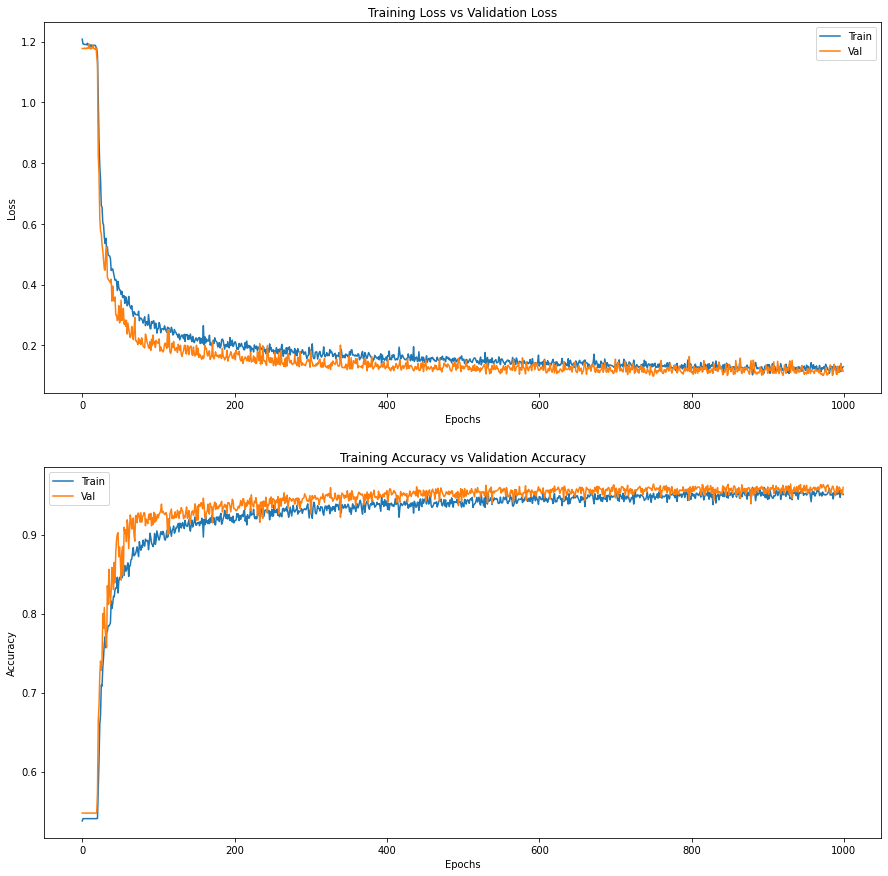

In [12]:
# Show Training Loss and Validation Loss
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [13]:
model.evaluate(x_test, y_test)

96/96 [==============================] - 0s 3ms/step - loss: 0.1160 - accuracy: 0.9566


[0.11598438769578934, 0.9566351771354675]

In [14]:
# Generates output predictions for the input samples
model_predictions = model.predict(x_test, batch_size=10, verbose=2)
model_predictions = tf.nn.softmax(model_predictions).numpy()
print(np.round(model_predictions, 4))

307/307 - 1s - 672ms/epoch - 2ms/step
[[0.4754 0.1749 0.1749 0.1749]
 [0.1794 0.4448 0.1952 0.1807]
 [0.4754 0.1749 0.1749 0.1749]
 ...
 [0.4754 0.1749 0.1749 0.1749]
 [0.4754 0.1749 0.1749 0.1749]
 [0.4754 0.1749 0.1749 0.1749]]


In [16]:
# Get predictions
predictions = []
# predictions are "rounded" to 1 or 0. If prediction is greater than others, it is assigned 1. Should have used argmax instead
for i,pred in enumerate(model_predictions):
    a = np.where(pred == np.max(pred), 1, 0)
#    a = np.where(a == np.max(a), 1, a)
#     a = np.where(pred == np.max(pred), 1, 0)
    predictions.append(a)

labels = []
# creating list of labels in order to compare with predictions
for i in y_test:
    if i == 0:
        a = [1, 0, 0, 0]
    if i == 1:
        a = [0, 1, 0, 0]
    if i == 2:
        a = [0, 0, 1, 0]
    if i == 3:
        a = [0, 0, 0, 1]
    labels.append(a)

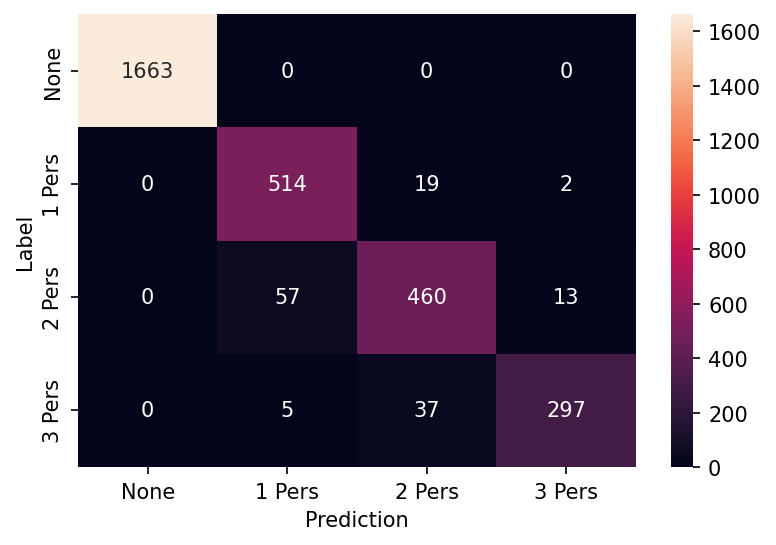

In [17]:
plt.rcParams['figure.dpi'] = 150
conf_matrix1 = np.zeros((4,4))

# Creating confusion matrix
for i in range(len(labels)):
    mat11 = np.asarray(labels[i])
    mat11 = mat11.reshape(4,1)
    mat12 = np.asarray(predictions[i])
    mat12 = mat12.reshape(1,4)

                
    conf_matrix1 += np.dot(mat11, mat12) #L2L

carlabels1 = ['None', '1 Pers', '2 Pers', '3 Pers']
    
sns.heatmap(conf_matrix1, xticklabels=carlabels1, yticklabels=carlabels1, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

c:\users\thedo\appdata\local\programs\python\python39\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


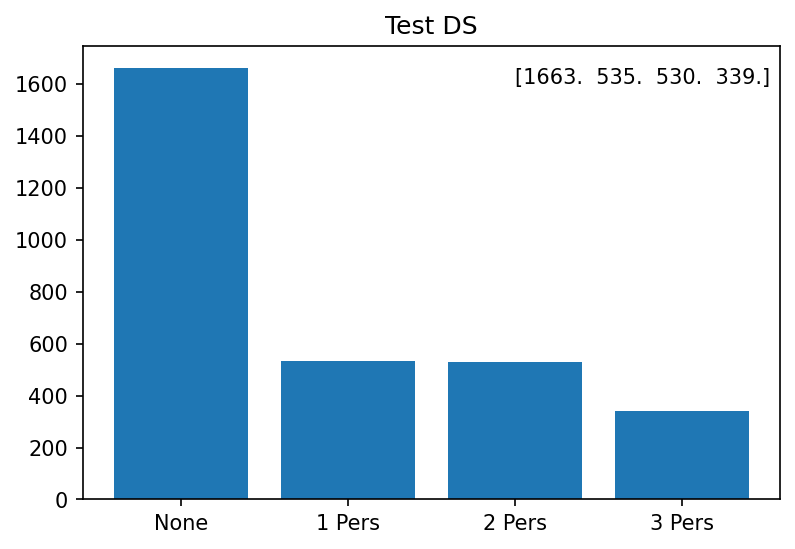

In [18]:
#Checking contents of validation dataset. As development could be done balancing classes.
bar1 = np.zeros(4)
bar2 = np.zeros(4)
ytrue1 = np.asarray(labels)

carlabels1 = ['None', '1 Pers', '2 Pers', '3 Pers']
    
for i in range(len(ytrue1)):
    bar1 += ytrue1[i]
    
plt.bar(carlabels1, bar1)
plt.text(2, 1600, bar1)
plt.title("Test DS")
plt.show()

#### !mkdir -p saved_model
model.save('saved_model/my_model')

In [19]:
model.save(export_dir)

INFO:tensorflow:Assets written to: mymodel\assets


In [20]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)